# IEEE Fraud Detection

# Packages nécessaires

In [1]:
import os
import numpy as np     
import pandas as pd   
import matplotlib.pyplot as plt   
import seaborn as sns        

from scipy import stats 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
import time
import random
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

sns.set() 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# Import des données

In [4]:
data_sub = pd.read_csv('sample_submission.csv')
data_sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [0]:
del data_sub

In [0]:
train_id = pd.read_csv('train_identity.csv')
train_trans = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')

In [7]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
TransactionID = test_id["TransactionID"]

In [0]:
#On rassemble les données train et test via la variable TransactionID.
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [0]:
del train_id, train_trans, test_id, test_trans

In [0]:
def reduce_mem_usage(df, verbose=True):
    """Réduction de la mémoire

    Parameters
    ----------
    df : data frame
    verbose : Booléen
        Afficher le pourcentage de réduction de mémoire


    Returns
    -------
    data frame
        Le data frame dont la mémoire est réduite
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


# Visualisation des données

**Données "object"**

In [13]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
print(cat_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


## Target : isFraud

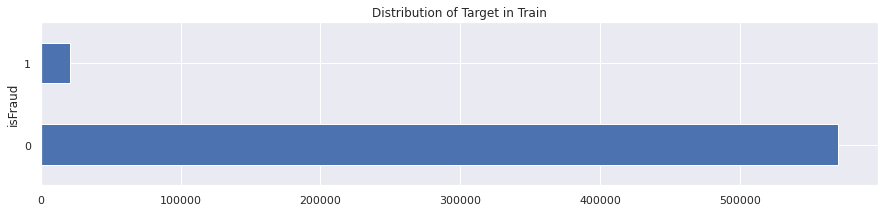

In [0]:
train.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

## Transaction Amt

In [0]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

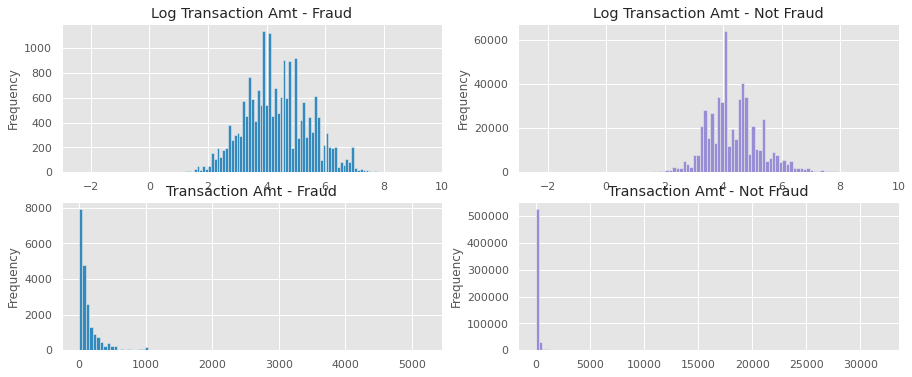

In [0]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()


In [0]:
print('Mean transaction amt for fraud is {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is inf
Mean transaction amt for non-fraud is nan


In [0]:
from scipy import stats
print(stats.ttest_ind(train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] ,train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] ,equal_var=False))

Ttest_indResult(statistic=0.0, pvalue=1.0)


## ProductCD

Le produit pour chaque transaction.

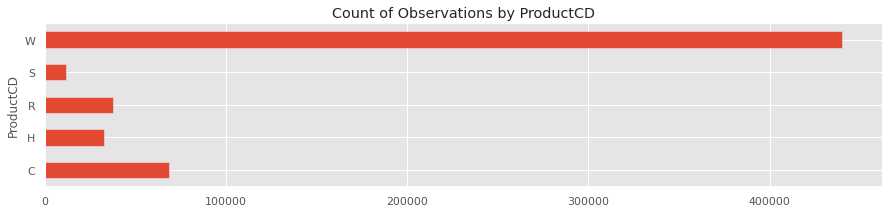

In [0]:
train.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

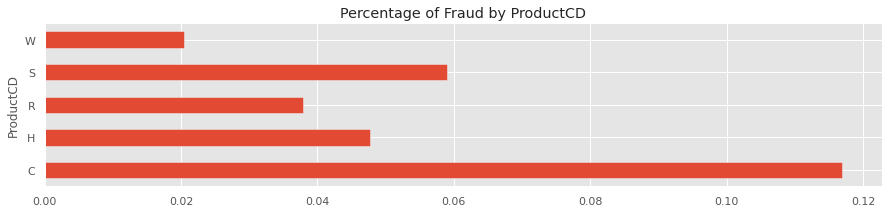

In [0]:
train.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

## card1 - card6

Informations sur les cartes de paiement.

In [0]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [0]:
color_idx = 0
for c in card_cols:
    if train[c].dtype in ['float64','int64']:
        train[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

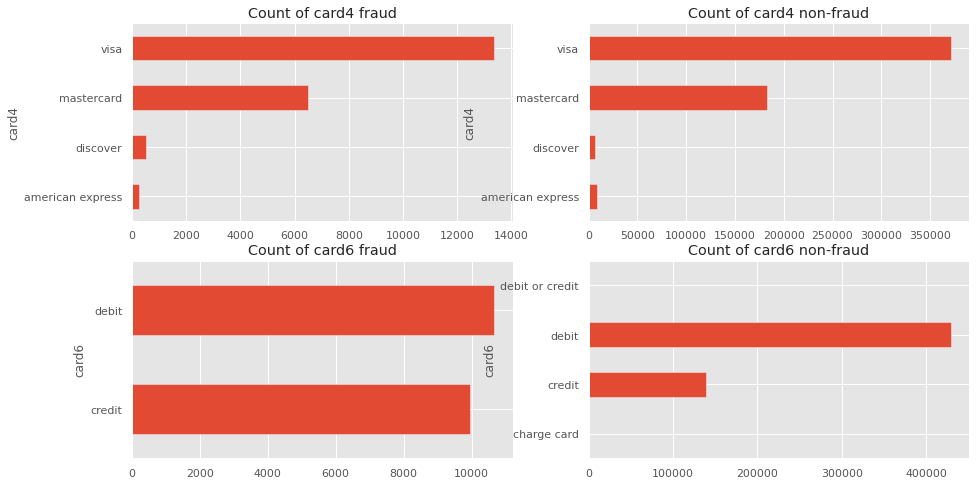

In [0]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

## DeviceType

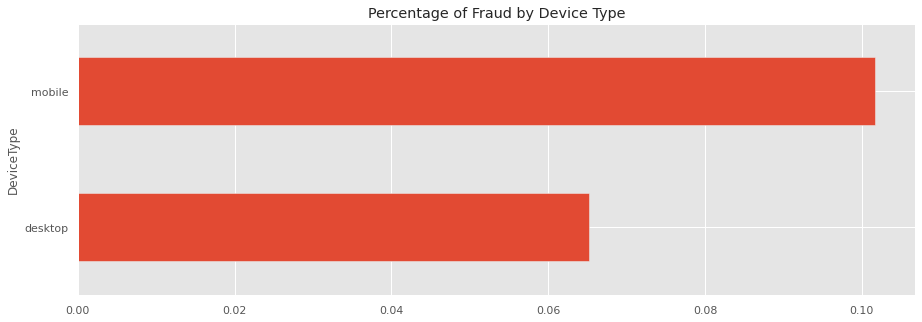

In [0]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

## DeviceInfo

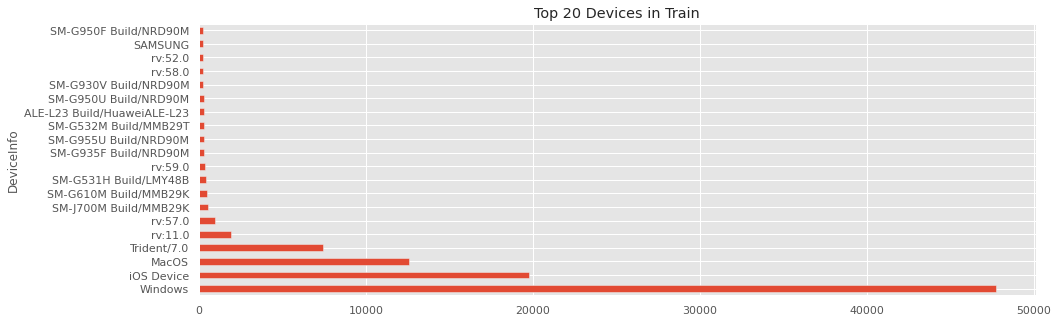

In [0]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

## TransactionDT

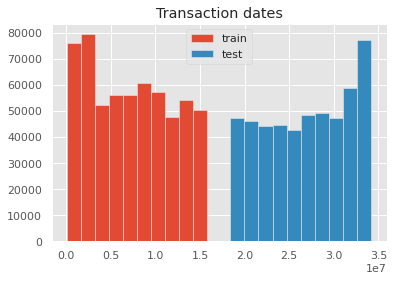

In [0]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Transaction dates');

Ci-dessus, on voit que les dates des données Train et Test ont une intersection vide.

In [14]:
y_train = train.isFraud
train = train.drop(['isFraud', 'TransactionID'],axis= 1)
transactionIDTest = test['TransactionID']
test = test.drop('TransactionID', axis= 1)
train.shape, test.shape

((590540, 432), (506691, 432))

# Valeurs manquantes

**Nettoyage des NaN**

**Train**

In [15]:
missing_values_count = train.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionDT         0
TransactionAmt        0
ProductCD             0
card1                 0
card2              8933
card3              1565
card4              1577
card5              4259
card6              1571
addr1             65706
dtype: int64
% of missing data =  45.283049553515994


On peut voir que 45% des données du train sont des valeurs manquantes, nettoyons tout ça !

In [16]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

 - On supprime les variables qui ont plus de 80% de NA

In [0]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.8]
    return many_null_cols

In [0]:
null_cols = get_too_many_null_attr(train)
train.drop(null_cols,1,inplace=True)

In [0]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

On peut voir que 88% des données sont des NaN, et 10% sont des valeurs nulles. Soit 98% des données sont des valeurs manquantes, donc inutiles !

On sépare les variables qualitatives et quantitatives : 

In [21]:
mask1 = train.dtypes==object
categoricalColumns = train.columns[mask1]
categoricalFeatures = train[categoricalColumns]
categoricalFeatures.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [22]:
mask2 = train.dtypes!=object
numericalColumns = train.columns[mask2]
numericalFeatures = train[numericalColumns]
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,100.0,NaN,166.0,542.0,144.0


## Corrélations entre les variables numériques

On cherche à observer visuellement s'il existe des corrélations entre certaines variables.

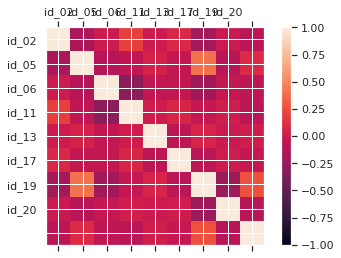

,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
id_01,1.000000,-0.142064,0.009666,0.201637,0.014431,0.088596,-0.180504,0.000519,-0.071238
id_02,-0.142064,1.000000,-0.101547,-0.047041,0.053744,-0.035814,0.412987,-0.093068,0.108523
id_05,0.009666,-0.101547,1.000000,-0.291584,-0.043001,-0.036637,-0.203021,-0.023800,-0.058070
id_06,0.201637,-0.047041,-0.291584,1.000000,0.020806,0.074835,-0.028708,0.029647,-0.071015
id_11,0.014431,0.053744,-0.043001,0.020806,1.000000,-0.063345,0.062676,0.004058,0.036318
id_13,0.088596,-0.035814,-0.036637,0.074835,-0.063345,1.000000,-0.075997,0.017657,-0.029427
id_17,-0.180504,0.412987,-0.203021,-0.028708,0.062676,-0.075997,1.000000,-0.214211,0.278472
id_19,0.000519,-0.093068,-0.023800,0.029647,0.004058,0.017657,-0.214211,1.000000,-0.088309
id_20,-0.071238,0.108523,-0.058070,-0.071015,0.036318,-0.029427,0.278472,-0.088309,1.000000


In [23]:
correlations = numericalFeatures[['id_01','id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['id_01','id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations


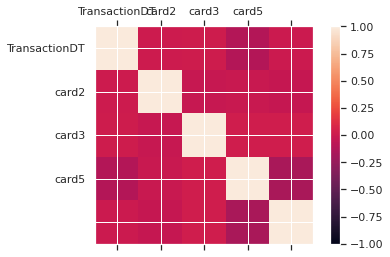

,TransactionAmt,TransactionDT,card2,card3,card5
TransactionAmt,1.000000,0.011920,0.016136,-0.109788,0.003061
TransactionDT,0.011920,1.000000,-0.019202,-0.011222,-0.024132
card2,0.016136,-0.019202,1.000000,0.023816,0.030486
card3,-0.109788,-0.011222,0.023816,1.000000,-0.158383
card5,0.003061,-0.024132,0.030486,-0.158383,1.000000


In [24]:
correlations = numericalFeatures[['TransactionAmt','TransactionDT','card2','card3','card5']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['TransactionAmt','TransactionDT','card2','card3','card5']
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

On remarque qu'il n'y a pas de corrélations flagrante entre ces variables.

 - Normalisation des variables numériques : 
 
 $\frac{X - \mu}{\sigma}$, avec $\mu$ : la moyenne de X et $\sigma$ : l'écart-type de X.

In [0]:
numericalFeatures = (numericalFeatures-numericalFeatures.mean())/numericalFeatures.std()

In [26]:
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
0,-1.577985,-0.278076,0.821695,NaN,-0.286621,-1.387695,0.238281,0.069641,-0.267578,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.208740,-0.054871,-0.087402,-0.047058,-0.243774,-0.147339,-0.509766,NaN,-0.245972,NaN,NaN,-0.607910,-0.718262,-0.807617,0.0,-0.187134,-0.24353,0.348389,0.258545,-0.191772,-0.240356,-0.146973,-0.185547,...,-0.040619,-0.06366,-0.045746,-0.033264,-0.055206,-0.100708,-0.141724,-0.094116,-0.099548,-0.157104,-0.16333,-0.522461,-0.454102,-0.500000,0.0,-0.059497,-0.066412,-0.076247,-0.094543,-0.334717,-0.041046,-0.227661,-0.222656,-0.249512,-0.22937,-0.048378,-0.032815,-0.058050,-0.055288,-0.088856,-0.074143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.577985,-0.443359,-1.457557,0.263184,-0.286621,-2.357422,0.336670,0.069641,NaN,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.268799,-0.054871,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,-0.732422,NaN,-0.679199,NaN,-0.807617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.040619,-0.06366,-0.045746,-0.058533,-0.055206,-0.100708,-0.141724,-0.094116,-0.099548,-0.157104,-0.16333,-0.522461,-0.454102,-0.500000,0.0,-0.059497,-0.093052,-0.076247,-0.094543,-0.334717,-0.041046,-0.227661,-0.222656,-0.249512,-0.22937,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.577970,-0.317871,-1.068262,0.808105,-0.286621,-0.806152,0.385742,0.069641,0.453369,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.208740,-0.054871,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,-0.732422,NaN,-0.679199,0.905273,0.746094,0.0,-0.187134,-0.24353,0.348389,0.258545,-0.191772,-0.240356,-0.146973,-0.185547,...,-0.040619,-0.06366,-0.045746,-0.058533,-0.055206,-0.100708,-0.141724,-0.094116,-0.099548,-0.157104,-0.16333,-0.522461,-0.454102,-0.500000,0.0,-0.059497,-0.093052,-0.076247,-0.094543,-0.334717,-0.041046,-0.227661,-0.222656,-0.249512,-0.22937,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.577964,-0.355469,1.679857,1.295898,-0.286621,-1.994141,1.820312,0.069641,NaN,-0.090515,-0.066467,-0.037506,-0.059448,-0.216064,-0.070923,-0.046143,-0.053955,-0.208740,-0.054871,-0.098022,-0.047058,-0.058228,-0.147339,0.111816,-0.324951,-0.454346,-0.240723,-0.47583,-0.218994,NaN,-0.260254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.040619,-0.06366,0.002798,0.902832,0.868652,-0.100708,-0.141724,-0.094116,-0.099548,-0.157104,-0.16333,-0.522461,-0.454102,-0.500000,0.0,-0.038210,0.307222,0.229849,-0.094543,0.667969,-0.041046,0.556641,-0.222656,-0.249512,-0.22937,-0.026351,0.290548,0.224765,-0.055288,-0.088856,-0.074143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.577962,-0.355469,-1.102132,0.960449,-0.286621,-2.357422,1.270508,0.069641,NaN,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.043457,-0.268799,-0.044403,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.040619,-0.06366,-0.045746,-0.058533,-0.055206,-0.100708,-0.141724,-0.094116,-0.099548,-0.157104,-0.16333,1.551758,1.149414,1.392578,0.0,-0.059497,-0.093052,-0.076247,-0.094543,-0.334717,-0.041046,-0.227661,-0.222656,-0.249512,-0.22937,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0.708984,-0.650977,NaN,NaN,0.221802,NaN,-0.773438,1.337891,-1.708984


Si une variable a la même valeur, la nouvelle valeur après normalisation sera égale à NaN. 

Ainsi, nous supprimerons les variables qui ont des NaN après la normalisation.

In [28]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNullScaled = numericalFeatures.columns[nonNull]
columnNonNullScaled

Index(['card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'D1', 'D2', 'D3',
       'D4',
       ...
       'V321', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17',
       'id_19', 'id_20'],
      dtype='object', length=315)

In [0]:
numericalFeatures = numericalFeatures.drop(columnNonNullScaled, axis = 1)

In [30]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [31]:
numericalFeatures.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype='object')

## Pré-traitement de l'échantillon Test

Dans un premier temps, on renomme le nom des colonnes de l'ensemble de données de test: on remplace - par _

In [0]:
droppedColumnsTest = []
for i in test.columns:
  a = i.replace('-','_')
  droppedColumnsTest.append(a)
test.columns = droppedColumnsTest

 - Extraction des variables numériques et qualitatives

In [0]:
X_testCategorical = test[categoricalFeatures.columns]

In [0]:
X_testNumerical  = test[numericalFeatures.columns]

 - Suppression des variables contenant plus de 80% de valeurs manquantes

In [0]:
null_cols = get_too_many_null_attr(X_testNumerical)
X_testNumerical.drop(null_cols,1,inplace=True)

In [36]:
X_testNumerical.isnull().sum()

TransactionDT        0
TransactionAmt       0
card1                0
C1                   3
C2                   3
C3                   3
C4                   3
C5                   3
C6                   3
C7                   3
C8                   3
C9                   3
C10                  3
C11                  3
C12                  3
C13               4748
C14                  3
dtype: int64

In [37]:
X_testNumerical.fillna(X_testNumerical.median(), inplace= True)
X_testNumerical.isnull().sum()

TransactionDT     0
TransactionAmt    0
card1             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
dtype: int64

On vérifie si les variables catégorielles du train et du test ont le même nombre de valeurs uniques avant l'encodage

In [38]:
categoricalFeatures.describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288,144233,140985,129340,140978,140978,140282,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2,2,3,2,2,2,130,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,Found,Found,Found,chrome 63.0,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656,123025,67728,66324,76232,74926,22000,77814,134066,110452,73922,85165,47722


In [39]:
X_testCategorical.describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,506691,503605,503684,437499,135870,330052,330052,330052,268946,197059,347752,271673,271687,271687,141907,136977,125747,136778,136778,136625,136977,136977,136977,136977,136931,115057
unique,5,4,3,60,60,2,2,2,3,2,2,2,2,2,2,3,2,2,2,135,2,2,2,2,2,2226
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,Found,Found,Found,chrome 70.0,T,F,T,F,desktop,Windows
freq,360987,334882,385021,207448,61738,330021,302855,266513,161384,107664,191577,233230,168399,236279,120895,67962,66481,75581,74338,16054,71650,133287,104697,95058,74403,44988


On remarque que certaines variables catégorielles ont une valeur unique différente dans le train et dans le test. 

Cela conduira à différentes formes du train et du test. On a alors décidé de supprimer ces variables.

Suppression des variables catégorielles ayant des valeurs uniques différentes dans le train et le test, avant l'encodage

In [40]:
A = []
for i in X_testCategorical.columns:
  if len(X_testCategorical[i].value_counts()) != len(categoricalFeatures[i].value_counts()):
    A.append(i)
A

['card6', 'P_emaildomain', 'id_31', 'DeviceInfo']

In [0]:
categoricalFeatures = categoricalFeatures.drop(A, axis = 1)
X_testCategorical = X_testCategorical.drop(A, axis = 1)

## Les chaînes de caractères : one hot encoder

On utilise la méthode _get_dummies_ pour coder les variables catégorielles du train et du test

In [0]:
def encodingTrain():
  x = pd.get_dummies(categoricalFeatures, columns= categoricalFeatures.columns)
  return x.join(numericalFeatures) 

In [0]:
X_trainEncoded = encodingTrain()

In [0]:
def encodingTest():
  x = pd.get_dummies(X_testCategorical, columns= X_testCategorical.columns) 
  return x.join(X_testNumerical)

In [0]:
X_testEncoded = encodingTest()

On vérifie la forme des ensembles du train et du test après l'encodage

In [46]:
X_trainEncoded.shape, X_testEncoded.shape, y_train.shape

((590540, 126), (506691, 126), (590540,))

On vérifie si y a pas de NAN dans le train et le test après l'encodage

In [47]:
nonNull = X_trainEncoded.isnull().sum() != 0
columnNonNull = X_trainEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [48]:
nonNull = X_testEncoded.isnull().sum() != 0
columnNonNull = X_testEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

On vérifie si le nom des colonnes dans le train et le test est le même

In [49]:
A = X_trainEncoded.columns == X_testEncoded.columns
A.sum() == len(X_trainEncoded.columns)

True

Le nom des colonnes dans le train et dans le test est le même. 

Nous définissons la fonction saveCSV pour la soumission sur Kaggle. Cette fonction renvoie les probabilités prédites enregistrées dans un fichier csv.

In [0]:
def saveCSV(predictedProba, filename="submission.csv"):
    predictedProba.to_csv(filename, index= False)

# Selection de variables avec Lasso

### Variables sélectionner par Lasso pour  $\lambda$=1

In [0]:
lasso = linear_model.Lasso(alpha=1)
lasso.fit(X_trainEncoded,y_train)
coef = lasso.coef_
col = X_trainEncoded.columns
var = col[coef!=0]
X_lasso = X_trainEncoded[var]

In [0]:
print(len(var))
print(var)

0
Index([], dtype='object')


###  Variables sélectionner par Lasso pour $\lambda$ =0.1 

In [0]:
lasso_01 = linear_model.Lasso(alpha=0.1)
lasso_01.fit(X_trainEncoded,y_train)
coef_01 = lasso_01.coef_
col_01 = X_trainEncoded.columns
var_01 = col_01[coef_01!=0]
X_lasso_01 = X_trainEncoded[var_01]

In [0]:
print(len(var_01))
print(var_01)

0
Index([], dtype='object')


# Prédiction de la probabilité du nombre de fraudes

In [0]:
Y = y_train 
X = X_trainEncoded

#### Split nos données en train(67%) et test(33%)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Naive Bayes

In [0]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(roc_auc_score(y_test,gnb.predict_proba(X_test)[:,1] ))

0.5217455403213918


## Knn

In [0]:
knn = KNeighborsClassifier()
# on crée un dictionnaire pour les nombres de voisins n_neighbors que l'on veut tester 
param_grid = {'n_neighbors': np.arange(1, 5)}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

#on fit le modèle
knn_best = knn_gscv.fit(X_train, y_train)

In [0]:
# la meilleure valeur de n_neighbors vaut 2
knn_gscv.best_params_

{'n_neighbors': 2}

In [0]:
#la moyenne des score pour cette valeur de n_neighbors 
knn_gscv.best_score_


0.9805970149253731

Pour cette valeur du nombre de voisins, l'accuracy sur le train est de 0.98

In [0]:
pred= knn_best.predict(X_test)
roc_auc_score(y_test, pred)

0.5

## Régression logistique

In [0]:
def temps(second):
    m, s = divmod(second, 60)
    h, m = divmod(m, 60)
    print("temps :",'{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s))

### Regression logistique avec toutes nos variables 

In [0]:
tstart = time.time()
log = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = log.predict_proba(X_train)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc train : 0.8054662789997558
temps : 00:00:23


In [0]:
tstart = time.time()
pred_test = log.predict_proba(X_test)
print("score auc test :",roc_auc_score(y_test, pred_test[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc test : 0.8097394092924868
temps : 00:00:00


### Regression logistique avec cross validation

#### cross validation sur toutes nos données avec les paramètres par défaut

In [0]:
tstart = time.time()
log_cv = LogisticRegression(random_state=0)
scores = cross_val_score(log_cv, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores)
tend = time.time()
temps(tend-tstart)

score auc : [0.75066592 0.7903439  0.78599131 0.82677556 0.80117794]
temps : 00:02:10


On peut constater que l'on obtient un auc de $\approx$ 0.827 qui est le plus élevé obtenu jusqu'à présent

### Optimisation des hyperparamètres

#### Identification des meilleurs paramètres pour la pénalité l2

In [0]:
lgr_l2 = LogisticRegression(penalty = 'l2', random_state = 0, n_jobs=-1)
params = {'solver' : ('newton-cg', 'lbfgs', 'sag', 'saga'), 'class_weight' :('balanced', None)}
lgr_l2_best = GridSearchCV(lgr_l2, params, scoring='roc_auc')
lgr_l2_best_fit = lgr_l2_best.fit(X_train,y_train)

In [0]:
lgr_l2_best.best_params_

{'class_weight': 'balanced', 'solver': 'newton-cg'}

In [0]:
lgr_l2_best.best_score_

0.8055216118850096

In [0]:
pred_test = lgr_l2_best_fit.predict_proba(X_test)
roc_auc_score(y_test, pred_test[:, 1])

0.8119454421906513

In [0]:
lgr_c = LogisticRegression(solver ='newton-cg', penalty = 'l2', class_weight = 'balanced', random_state = 0, n_jobs=-1)
params = {'C': np.arange(1,10,1)}
lgr_c_best = GridSearchCV(lgr_c, params, scoring='roc_auc')
lgr_c_best_fit = lgr_c_best.fit(X_train,y_train)

In [0]:
lgr_c_best.best_params_

{'C': 9}

In [0]:
lgr_c_best.best_score_

0.8055401953763077

In [0]:
pred_test = lgr_c_best_fit.predict_proba(X_test)
roc_auc_score(y_test, pred_test[:, 1])

0.8120140496615683

Nous obtenons que pour la pénalité l2, les meilleurs paramètres sont solver ='newton-cg', C=9 et class_weight = 'balanced'.

#### Identification des meilleurs paramètres pour la pénalité l1

Le solver 'saga' est un solver qui fonctionne bien avec la pénalité l1 et avec les grands jeu de données, ce qui est notre cas ici.

In [0]:
lgr_l1 = LogisticRegression(solver ='saga', penalty = 'l1', random_state = 0, n_jobs=-1)
params = {'C': np.arange(0.1,1.1,0.1), 'class_weight' :('balanced', None)}
lgr_l1_best = GridSearchCV(lgr_l1, params, scoring='roc_auc')
lgr_l1_best_fit = lgr_l1_best.fit(X_train,y_train)

In [0]:
lgr_l1_best.best_params_

{'C': 1.0, 'class_weight': 'balanced'}

In [0]:
lgr_l1_best.best_score_

0.7996787106833854

In [0]:
pred_test = lgr_l1_best_fit.predict_proba(X_test)
roc_auc_score(y_test, pred_test[:, 1])

0.8067764236155932

In [0]:
lgr_l1_ = LogisticRegression(solver ='saga', penalty = 'l1', random_state = 0, class_weight = 'balanced', n_jobs=-1)
params = {'C': np.arange(1,11,1)}
lgr_l1_best_ = GridSearchCV(lgr_l1_, params, scoring='roc_auc')
lgr_l1_best_fit_ = lgr_l1_best_.fit(X_train,y_train)

In [0]:
lgr_l1_best_.best_params_

{'C': 10}

In [0]:
lgr_l1_best_.best_score_

0.7997057435970527

In [0]:
pred_test = lgr_l1_best_fit_.predict_proba(X_test)
roc_auc_score(y_test, pred_test[:, 1])

0.8067960983068643

Nous obtenons que pour la pénalité l1, les meilleurs paramètres sont C=10 et class_weight = 'balanced'.

#### Comparaison entre la pénalité l1 et l2

La pénalité l1 n'est pas supporté par le solver 'newton-cg'. Toutefois, les pénalités l1 et l2 fonctionnent toute les deux avec le solver 'saga'.

In [0]:
lgr_l1_l2 = LogisticRegression(solver ='saga', class_weight = 'balanced', random_state = 0, n_jobs=-1)
params = {'penalty' : ('l2','l1'), 'C':[9,10]}
lgr_l1_l2_best = GridSearchCV(lgr_l1_l2, params, scoring='roc_auc')
lgr_l1_l2_best_fit = lgr_l1_l2_best.fit(X_train,y_train)

In [0]:
lgr_l1_l2_best.best_params_

{'C': 10, 'penalty': 'l2'}

Nous obtenons que la meilleure pénalité est la l2 et pour C=10 pour le solver 'saga'.

#### Identification des meilleurs paramètres pour la pénalité elasticnet 

La pénalité elasticnet est une pénalité qui se base sur la l1 et l2 en fonction du l1_ration. Plus ce ration est proche de 1, plus la pénalité est semblable à la l1. Si ce ratio est égale à 0, cela correspond à une pénalité l2 et s'il est égale à 1, à une pénalité l1. 

La pénalité elasticnet est supporté qu'avec le solver 'saga'.

In [0]:
lgr_elas = LogisticRegression(solver = 'saga', penalty = 'elasticnet', random_state = 0, class_weight='balanced', n_jobs=-1)
params = {'l1_ratio' : np.arange(0,1.1,0.1)}
lgr_elas_best = GridSearchCV(lgr_elas, params, scoring='roc_auc')
lgr_elas_best_fit = lgr_elas_best.fit(X_train,y_train)

In [0]:
lgr_elas_best.best_params_

{'l1_ratio': 0.0}

In [0]:
lgr_elas_best.best_score_

0.7996890378398178

In [0]:
pred_test = lgr_elas_best_fit.predict_proba(X_test)
roc_auc_score(y_test, pred_test[:, 1])

0.8067821338187913

Nous avons comme meilleur paramètre un ratio égalé à 0, ce qui est équivalent à prendre la pénalité l2.

#### Kfold avec les meilleurs paramètres

In [0]:
tstart = time.time()
lgr_best = LogisticRegression(solver = 'newton-cg', penalty = 'l2', C=9, class_weight = 'balanced', n_jobs=-1, random_state=0)
scores = cross_val_score(lgr_best, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores)
tend = time.time()
temps(tend-tstart)

score auc : [0.76952744 0.78977571 0.78636476 0.82787014 0.80076755]
temps : 01:41:19


Nous obtenons un auc allant jusqu'à 0.827.

## Random Forest

In [0]:
#Création du modèle
tstart = time.time()
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 40,max_features = 'sqrt')
rf_fit=rf.fit(X_train, y_train)
tend = time.time()
temps(tend-tstart)

temps : 00:00:17


Après quelques secondes d'entrainement, le modèle est prêt à faire des prédictions sur les données de test comme suit:

In [0]:
tstart = time.time()
rf_predict = rf.predict(X_test)
tend = time.time()
temps(tend-tstart)

temps : 00:00:01


On peut voir combien de noeuds il y a en moyenne pour chaque arbre et la profondeur maximale de chaque arbre. 

In [0]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')



Average number of nodes 33829
Average maximum depth 49


On peut voir que chaque arbre de décision dans la forêt a de nombreux noeuds et est extrêmement profond. Cependant, même si chaque arbre de décision individuel peut s'adapter à un sous-ensemble particulier des données d'entrainement, l'idée est que la forêt aléatoire globale devrait avoir une variance réduite.

**Evaluation des performances:**


Area under the ROC curve : 0.930455


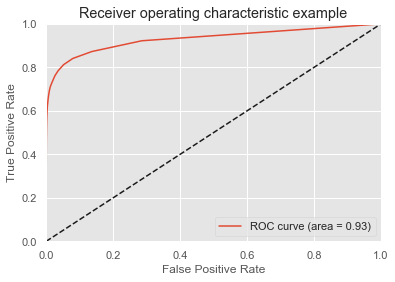

In [0]:
from sklearn.metrics import roc_curve, auc

probas = rf.predict_proba(X_test)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe

fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right");

- Matrice de confusion

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[187717    216]
 [  3238   3708]]


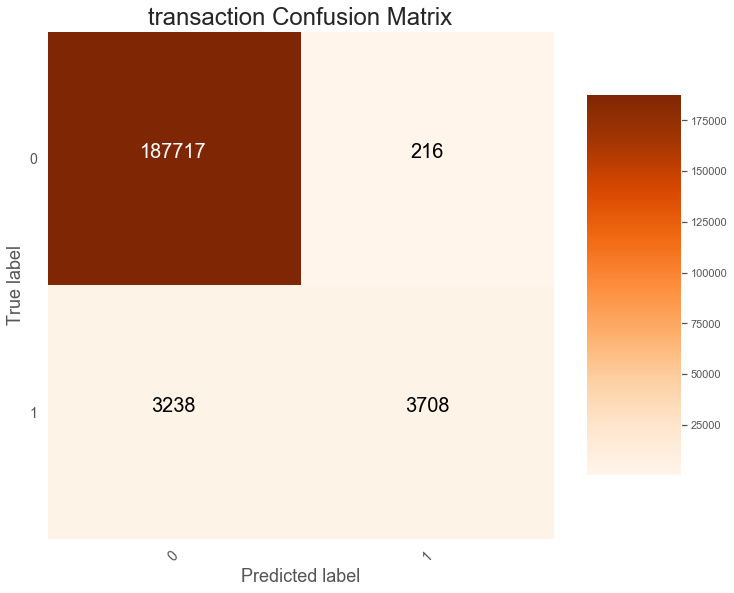

In [0]:
cm = confusion_matrix(y_test, rf_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'transaction Confusion Matrix')


Cela montre les classifications prévues par le modèle sur les données de test ainsi que les labels réels. Nous pouvons voir que notre modèle a de nombreux faux positifs (une transaction non frauduleuse prédite mais en fait une transaction frauduleuse)

**Optimisation Random Forest:**

- **Option 1:**

On a utilisé RandomizedSearchCV de sklearn pour optimiser nos hyperparamateurs on a décidé de se concentrer sur 3 hyperparamètres: n_estimators, max_features et max_depth.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)
print(rfc_random.best_params_)

- **Option 2:**

Afin de maximiser les performances de notre modèle, on peut effectuer une recherche aléatoire de meilleurs hyperparamètres. Cela sélectionnera de manière aléatoire des combinaisons d'hyperparamètres à partir d'une grille, les évaluera à l'aide d'une validation croisée sur les données d'entraînement et renverra les valeurs les plus performantes.

In [0]:
RSEED=50
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

On a fait tourner cette partie du code sur un ordinateur plus puissant, l'agorithme a fait 300 calculs et 3 fit et pour chaque fit 100 estimation. temps de calcul 9h 

Résultat: n_estimators = 485, max_features='sqrt',max_depth=164

**Variables importantes:**

On jete un oeil aux variables considérées comme les plus importantes par notre modèle. Les valeurs sont calculées se basant sur le coefficient de Gini de l'impureté d'un noeud.

In [0]:
fi = []
fiName = []
for feat, importance in zip(X.columns, rf.feature_importances_):
  if importance!= 0:
      fi.append(importance)
      fiName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: ProductCD_C, importance: 0.004154933697053081
feature: ProductCD_H, importance: 0.0026548589477266983
feature: ProductCD_R, importance: 0.0017924443845828667
feature: ProductCD_S, importance: 0.0015268560632431994
feature: ProductCD_W, importance: 0.0006456769144813297
feature: card4_american express, importance: 0.0011212459464125838
feature: card4_discover, importance: 0.003510484230494532
feature: card4_mastercard, importance: 0.01004019689366148
feature: card4_visa, importance: 0.01058574860279832
feature: R_emaildomain_aim.com, importance: 4.219884864920845e-05
feature: R_emaildomain_anonymous.com, importance: 0.004740872779379804
feature: R_emaildomain_aol.com, importance: 0.0008225190009040987
feature: R_emaildomain_att.net, importance: 5.2228840617408393e-05
feature: R_emaildomain_bellsouth.net, importance: 4.172146276808486e-05
feature: R_emaildomain_cableone.net, importance: 1.086113118724693e-06
feature: R_emaildomain_centurylink.net, importance: 4.886501849679743e-

In [0]:
len(fi)

126

On a au total 126 variables importantes.

On trace 10 variables importantes retourner par notre modèle

No handles with labels found to put in legend.


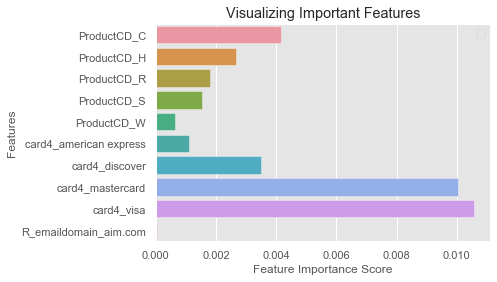

In [0]:
sns.barplot(x=fi[0:10], y=fiName[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

**Utilisation du meilleur modèle (variables importantes)**

Maintenant, on va prendre le meilleur modèle (qui a été formé) et l'évaluer. Espérons que celui là retourne un meilleur résultat

In [0]:
X_trainEncodedBest = X_train[fiName]
X_testEncodedBest = X_test[fiName]

- **Option 1:**

In [0]:
rf_best=RandomForestClassifier( n_estimators = 485, max_features='sqrt',max_depth=164)

In [0]:
tstart=time.time()
rf_best.fit(X_trainEncodedBest,y_train)
tend = time.time()
temps(tend-tstart)

temps : 00:08:01


In [0]:
rf_predict_best = rf_best.predict(X_testEncodedBest)

Confusion matrix, without normalization
[[187714    219]
 [  3166   3780]]


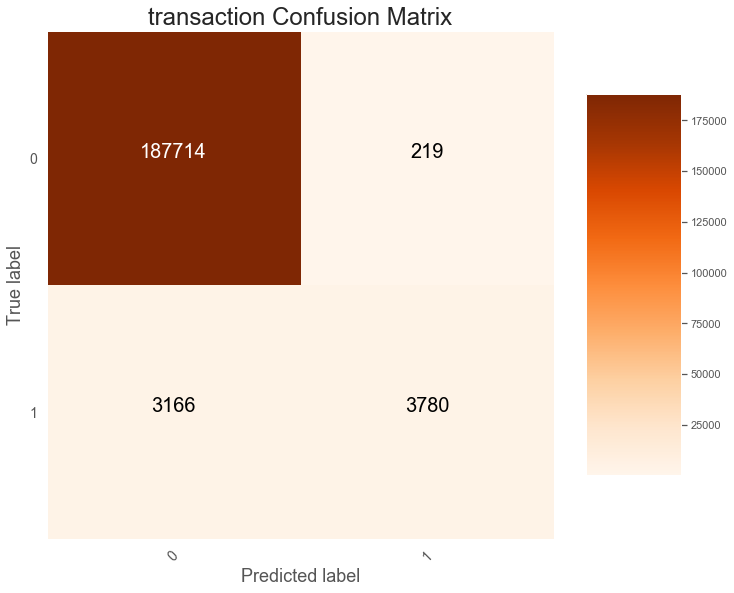

In [0]:
cm = confusion_matrix(y_test, rf_predict_best)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'transaction Confusion Matrix')

Area under the ROC curve : 0.944634


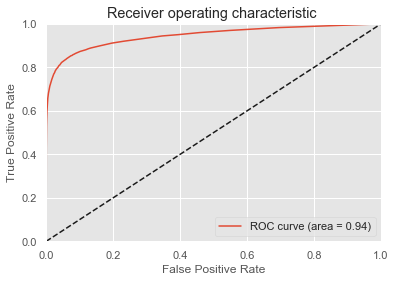

In [0]:
from sklearn.metrics import roc_curve, auc

probas = rf_best.predict_proba(X_testEncodedBest)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe

fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right");

- **Option 2:**

In [0]:
rf_best2=RandomForestClassifier(n_estimators = 188,min_samples_split=2,max_leaf_nodes= 33,max_features=0.79
                               ,max_depth=12,bootstrap= True)

In [0]:
tstart=time.time()
rf_best2.fit(X_trainEncodedBest_rf,y_train)
tend = time.time()
temps(tend-tstart)

In [0]:
rf_predict_best2 = rf_best2.predict(X_testEncodedBest_rf)

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test,rf_predict_best2 ))

## Adaptive Boosting

Optimisation des hyperparamètres

In [0]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 1]}
gridCv = GridSearchCV(AdaBoostClassifier(), param_grid= parameters, cv=3, scoring='roc_auc')

In [0]:
begin = time.time()
gridCv.fit(X,Y)
end = time.time()

In [0]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

Time execution for optimizing hyperparapeter is 9.452148266633351 minutes.


Meilleur paramètre, meileur estimateur et AUC

In [0]:
gridCv.best_params_

{'learning_rate': 1}

In [0]:
gridCv.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [0]:
gridCv.best_score_

0.8237338656984755

Model AdaBoost avec toutes les variables

In [0]:
Model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate= 1,
                   n_estimators=50, random_state=None)

In [0]:
Model.fit(X,Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

Probabilités prédites par le modèle

In [0]:
predictedProba1 = pd.DataFrame(Model.predict_proba(X_testEncoded), columns=['0','1'])
fraudTransaction = predictedProba1['1']

In [0]:
fraudTransactionADB = saveCSV(fraudTransaction, filename="submission.csv")

Adaboost Model avec seulement les variables importantes :

On utilise la méthode feature_importances_ pour trouver les variables importantes.

In [0]:
importantFeature = []
importantFeatureName = []
for feat, importance in zip(X.columns, gridCv.best_estimator_.feature_importances_):
  if importance!= 0:
      importantFeature.append(importance)
      importantFeatureName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: ProductCD_R, importance: 0.02
feature: card4_discover, importance: 0.02
feature: card4_visa, importance: 0.02
feature: R_emaildomain_gmail.com, importance: 0.02
feature: M3_T, importance: 0.02
feature: M4_M0, importance: 0.02
feature: M5_T, importance: 0.02
feature: M6_F, importance: 0.02
feature: M9_F, importance: 0.02
feature: id_29_Found, importance: 0.02
feature: DeviceType_mobile, importance: 0.02
feature: TransactionDT, importance: 0.04
feature: TransactionAmt, importance: 0.06
feature: card1, importance: 0.08
feature: C1, importance: 0.12
feature: C2, importance: 0.02
feature: C3, importance: 0.02
feature: C5, importance: 0.04
feature: C6, importance: 0.04
feature: C7, importance: 0.08
feature: C8, importance: 0.04
feature: C11, importance: 0.06
feature: C12, importance: 0.02
feature: C13, importance: 0.04
feature: C14, importance: 0.12


In [0]:
X_trainEncodedBest = X_train[importantFeatureName]
X_testEncodedBest = X_test[importantFeatureName]

In [0]:
begin = time.time()
crossValScore = cross_val_score(Model, X_trainEncodedBest, y_train, cv= 3, scoring='roc_auc')
end = time.time()

In [0]:
print("auc score is: {f}".format(f=np.mean(crossValScore)))
print("Time exécution is {a} minutes".format(a = (end-begin)/60))

auc score is: 0.8435041254731782
Time exécution is 0.6441983938217163 minutes


On obtient un auc_score supérieur.

Probabilités des transactions frauduleuse prédites par ce modèle

Le modèle prenant en compte toutes les variables prend assez de temps et donne  une plus petite valeur de l'AUC (0.82).

En ne prenant que les variables importantes on trouve un score de l'AUC de 0.84 avec un temps d'exécution est moins long.

In [0]:
seed = 7
# preparation des models optimisés
models = []
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2)))
models.append(('LR', LogisticRegression(solver = 'newton-cg', penalty = 'l2', C=9, class_weight = 'balanced', n_jobs=-1, random_state=0)))
models.append(('RF', RandomForestClassifier(n_estimators = 485, max_features='sqrt',max_depth=164)))
models.append(('ADB', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate= 1,
                   n_estimators=50, random_state=None)))

# évalutation de chaque model
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

NB: 0.509076 (0.004409)


# Comparaison 

In [53]:
seed = 7
# preparation des models optimisés
models = []
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2)))
models.append(('LR', LogisticRegression(solver = 'newton-cg', penalty = 'l2', C=9, class_weight = 'balanced', n_jobs=-1, random_state=0)))
models.append(('RF', RandomForestClassifier(n_estimators = 485, max_features='sqrt',max_depth=164)))
models.append(('ADB', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate= 1,
                   n_estimators=50, random_state=None)))

# évalutation de chaque model
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

NB: 0.509076 (0.004409)
KNN: 0.630214 (0.019375)
LR: 0.797934 (0.018564)
RF: 0.886692 (0.009569)
ADB: 0.832397 (0.009978)


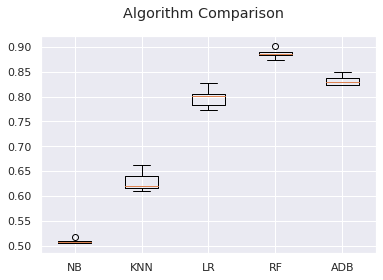

In [54]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Conclusion

Le random forest et l'algorithme adaptative adaboosting donnent des meilleurs accuracy_score. 